In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

In [41]:
c = np.load("casper/calib.npy", allow_pickle=True).item()
c

{'K0': array([[1.09058826e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09058826e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd0': array([-0.03720395, -0.2353958 ,  0.        ,  0.        ,  0.        ]),
 'K1': array([[1.09454675e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09454675e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd1': array([-0.04744541, -0.00026868,  0.        ,  0.        ,  0.        ]),
 'R': array([[ 0.91398722, -0.07814026,  0.39814758],
        [ 0.07619891,  0.99687725,  0.02072451],
        [-0.39852369,  0.01139647,  0.91708726]]),
 't': array([[-407.240143 ],
        [  -1.5053668],
        [  85.688652 ]])}

## Ex 13.2

In [42]:
im0 = cv2.imread("casper/sequence/frames0_0.png")
im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY)
im0 = im0.astype(float) / 255
size = (im0.shape[1], im0.shape[0])
stereo = cv2.stereoRectify(
    c["K0"], c["d0"], c["K1"], c["d1"], size, c["R"], c["t"], flags=0
)
R0, R1, P0, P1 = stereo[:4]
maps0 = cv2.initUndistortRectifyMap(c["K0"], c["d0"], R0, P0, size, cv2.CV_32FC2)
maps1 = cv2.initUndistortRectifyMap(c["K1"], c["d1"], R1, P1, size, cv2.CV_32FC2)
# im0 should come from maps0
im0_rect = cv2.remap(im0, *maps0, cv2.INTER_LINEAR)

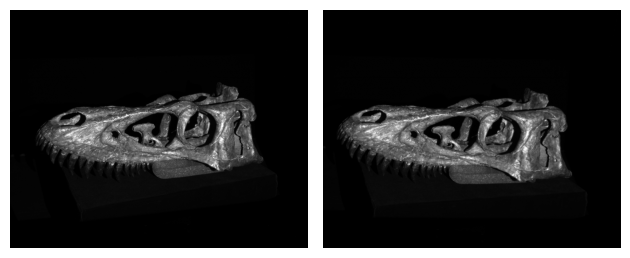

In [43]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im0, cmap="gray")
axes[0].axis('off')
axes[1].imshow(im0_rect, cmap="gray")
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import re

def extract_number(filename):
    match = re.search(r"_(\d+)\.png$", filename)
    return int(match.group(1)) if match else 0


In [47]:
folder_path = "casper/sequence/"
cam_0_ims0 = []
cam_0_ims1 = []
for name in sorted(glob.glob(folder_path + "frames0*.png"), key=extract_number):
    image = cv2.imread(name)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image.astype(float) / 255
    image_rect = cv2.remap(image, *maps0, cv2.INTER_LINEAR)
    cam_0_ims0.append(image)
    cam_0_ims1.append(image_rect)
len(cam_0_ims0), len(cam_0_ims1)

(26, 26)

In [ ]:
folder_path = "casper/sequence/"
cam_1_ims0 = []
cam_1_ims1 = []
for name in sorted(glob.glob(folder_path + "frames1*.png"), key=extract_number):
    print(name)
    image = cv2.imread(name)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image.astype(float) / 255
    image_rect = cv2.remap(image, *maps0, cv2.INTER_LINEAR)
    cam_1_ims0.append(image)
    cam_1_ims1.append(image_rect)
len(cam_1_ims0), len(cam_1_ims1)

(26, 26)

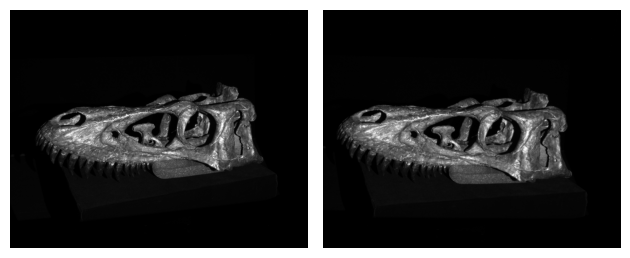

In [48]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cam_0_ims0[0], cmap="gray")
axes[0].axis("off")
axes[1].imshow(cam_0_ims1[0], cmap="gray")
axes[1].axis("off")
plt.tight_layout()
plt.show()

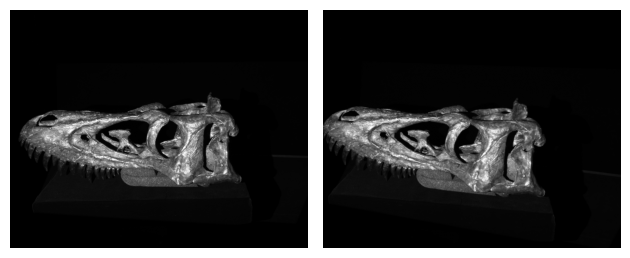

In [50]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cam_1_ims0[0], cmap="gray")
axes[0].axis("off")
axes[1].imshow(cam_1_ims1[0], cmap="gray")
axes[1].axis("off")
plt.tight_layout()
plt.show()

## Ex 13.3
At this point, we are ready to make a function that can compute the phases for each camera theta
= unwrap(ims). I suggest to write the code for camera 0 and to put it into a function once it’s working.
* Use indexing to get a list of the primary images out, and make sure it has length 16. 
* Put this list into the Fast Fourier Transform (np.fft.rfft) to find the Fourier spectrums of the primary images (fft_primary). We use rfft as the input is only real numbers. The function can operate on a list of arrays, which is ideal for our situation. Make sure to specify that the FFT should
operate along the first dimension of the array (axis=0). The Fourier component corresponding to the pattern is in the second component (fft_primary[1]).
* Get the phase of this using np.angle and call it theta_primary.
* Repeat the same steps for the secondary phase to obtain theta_secondary. * Compute the phase cue (theta_c) using the heterodyne principle.
* Find the order (o_primary) of the primary phase.
Use the order of the primary phase to obtain the unwrapped phase (theta).
Wrap all of the above into a function theta = unwrap(ims) and use it to obtain the phase for both cameras (theta0 and theta1)

2-17 are the 16 images in the primary pattern shifting. This pattern has 40 periods.
18-25 are the 8 images of the secondary pattern shifting. This pattern has 41 periods.

In [65]:
cam0_primary = cam_0_ims1[2: 18]
cam0_secondary = cam_0_ims1[18: 26]
cam1_primary = cam_1_ims1[2: 18]
cam1_secondary = cam_1_ims1[18: 26]
len(cam0_primary), len(cam1_primary)

(16, 16)

![unwrapping](images/unwrapping.png)

In [ ]:
fft_primary = np.fft.rfft(cam0_primary, axis=0)
fft_primary.shape, fft_primary[1]
theta_primary = np.angle(fft_primary[1])
fft_secondary = np.fft.rfft(cam0_secondary, axis=0)
fft_secondary.shape, fft_secondary[1]
theta_secondary = np.angle(fft_secondary[1])
theta_c = (theta_secondary - theta_primary) % (2 * np.pi)
n_primary = 40
o_primary = (n_primary * theta_c - theta_primary) / (2 * np.pi)
theta_est = ((2 * np.pi * o_primary + theta_primary) / n_primary) % (2 * np.pi)


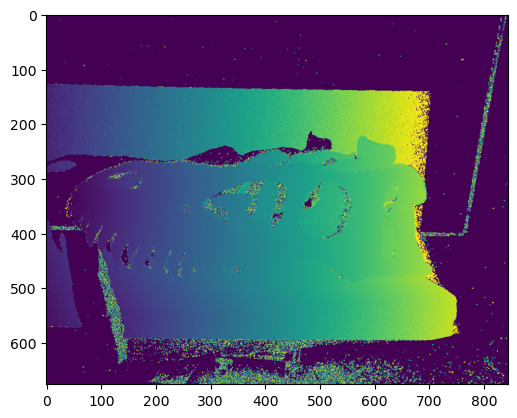

In [73]:
plt.imshow(theta_est)